In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from src.utils import *
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Load data (just after splitting)
train_images = np.load("../data/images/train_images.npy")
test_images = np.load("../data/images/test_images.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_labels = np.load("../data/labels/test_labels.npy")
train_tracks = np.load("../data/tracks/train_tracks.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

# Load full data

x_train_full = np.load('../data/images/time_norm_train_images.npy')[:,0,:,:]
#y_train_full = np.load('./data/labels/train_labels_augmented4.npy')
#x_test = np.load('./data/images/time_norm_test_images.npy')[:,0,:,:]
#y_test = np.load('./data/labels/test_labels.npy')

In [3]:
less_indexes = np.random.choice(np.arange(len(train_labels)), int(0.1 * len(train_labels)), replace=False)

train_tracks[less_indexes][:,0,4:17].shape

(110, 13)

In [9]:
dataset_size = [0.6, 0.7, 0.8, 0.9] # will probably have to try with different seeds #, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9

# Will use frame 0

#### FIGURE OUT WHY IT'S NOT WORKING FOR THE NEXT SIZE, AND WHY THE TABULAR DATA HAS AN ERROR
def data_size_study(dataset_size, train_images, train_labels, train_tracks, test_images, test_labels, test_tracks, x_train_full, seed=42):

    np.random.seed(seed)
    confusion_matrices_cellfate = np.zeros((len(dataset_size), 2, 2))
    confusion_matrices_tabular = np.zeros((len(dataset_size), 2, 2))

    for size in dataset_size:
        
        # Create new output directory folder with the size 

        output_dir=f"../results/data_labelling_study/split_{size}"
        os.makedirs(output_dir, exist_ok=True)

        less_indexes = np.random.choice(np.arange(len(train_labels)), int(size * len(train_labels)), replace=False)

        # Get less training data
        smaller_x_train_images = train_images[less_indexes]
        smaller_y_train = train_labels[less_indexes]
        smaller_x_train_tracks = train_tracks[less_indexes]

        # Augment image data
        smaller_train_images_augmented, smaller_train_labels_augmented = augment_dataset(smaller_x_train_images, smaller_y_train, augmentations)

        # Stretch intensities of new images (train and test)
        stretched_x_train_smaller, stretched_x_test = stretch_intensities_global(smaller_train_images_augmented, test_images)

        # Pick only frame zero
        x_train = stretched_x_train_smaller[:,0,:,:]
        y_train = smaller_train_labels_augmented
        x_test = stretched_x_test[:,0,:,:]
        y_test = test_labels

        print("X_train size: ", x_train.shape, "Y_train size: ", y_train.shape, "X_test size: ", x_test.shape, "Y_test size: ", y_test.shape)

        # IMAGES: Train autoencoder only
        
        config_ae = {
            'batch_size': 30,
            'epochs': 15,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 5,
            'lambda_adv': 1,
        }

        config_cellfate = {
            'batch_size': 30,
            'epochs': 100,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 6,
            'lambda_adv': 4,
            'lambda_cov': 0.0001,
            'lambda_contra': 8,
        }

        config_clf = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
        }

        results_autoencoder = train_autoencoder(config_ae, x_train_full)
        encoder = results_autoencoder['encoder']
        decoder = results_autoencoder['decoder']
        discriminator = results_autoencoder['discriminator']

        # IMAGES: Train AIcellfate with smaller dataset

        results_cellfate = train_cellfate(config_cellfate, encoder, decoder, discriminator, x_train, y_train, x_test, y_test) #lambda_recon=scaled_autoencoder_results['lambda_recon'], lambda_adv=scaled_autoencoder_results['lambda_adv']
        encoder = results_cellfate['encoder']
        decoder = results_cellfate['decoder']
        discriminator = results_cellfate['discriminator']

        save_model_weights_to_disk(encoder, decoder, discriminator, output_dir=output_dir)
        
        evaluator = Evaluation(output_dir)

        # Evaluate the model (and saving everything)
        z_imgs = encoder.predict(x_train)
        recon_imgs = decoder.predict(z_imgs)
        evaluator.reconstruction_images(x_train, recon_imgs[:,:,:,0], epoch=0)
        evaluator.visualize_latent_space(z_imgs, y_train, epoch=0)
        cov_matrix = cov_loss_terms(z_imgs)[0]
        evaluator.plot_cov_matrix(cov_matrix, epoch=0) # the epoch is a placeholder, it doesnt mean anything (TODO: change these functions)

        tf.keras.utils.set_random_seed(config_clf['seed'])

        classifier = mlp_classifier(latent_dim=config_clf['latent_dim'])
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_clf['learning_rate']), metrics=['accuracy'])

        x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) 
        history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config_clf['batch_size'], epochs=config_clf['epochs'], validation_data=(x_val, y_val)) 

        y_pred = classifier.predict(x_test_)
        y_pred_classes = np.argmax(y_pred, axis=1)
        num_classes = len(np.unique(y_test_))

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums
        
        confusion_matrices_cellfate[dataset_size.index(size)] = conf_matrix_normalized

        # Save confusion matrix
        plot_confusion_matrix(y_test_, y_pred, num_classes)
        np.save(f"{output_dir}/confusion_matrices_cellfate.npy", confusion_matrices_cellfate)

        # TODO: add perturbations ?

        # TRACKS: train classifier

        config_tracks = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': 42,
        }
        
        train_tracks_ = smaller_x_train_tracks[:,0,4:17]
        test_tracks_ = test_tracks[:,0,4:17]
        train_labels_ = smaller_y_train
        test_labels_ = test_labels

        print("Train tracks shape: ", train_tracks_.shape)

        class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_.flatten()), y=train_labels_.flatten())
        class_weights = dict(enumerate(class_weights))

        tf.keras.utils.set_random_seed(seed)

        classifier = complex_mlp_classifier(latent_dim=train_tracks_.shape[1]) #[:, [3, 8]] 
        #classifier = simple_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1])

        # Train the classifier
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_tracks['learning_rate']), metrics=['accuracy'])
        classifier.summary()

        x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_, test_labels_, test_size=0.5, random_state=42) # 42 random state

        history = classifier.fit(train_tracks_, train_labels_, batch_size=config_tracks['batch_size'], epochs=config_tracks['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) 

        y_pred = classifier.predict(x_test_tracks)

        num_classes = len(np.unique(train_labels_))
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_tracks, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums

        print(conf_matrix_normalized)

        confusion_matrices_tabular[dataset_size.index(size)] = conf_matrix_normalized
        np.save(f"{output_dir}/confusion_matrices_tabular.npy", confusion_matrices_tabular)

    return confusion_matrices_cellfate, confusion_matrices_tabular


#np.save("../results/data_labelling_study/smaller_x_train_images.npy", smaller_x_train_images)

X_train size:  (1200, 20, 20) Y_train size:  (1200,) X_test size:  (277, 20, 20) Y_test size:  (277,)
Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 42, latent dim: 2


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.2867, Adversarial loss: 0.7489, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.7749, Adversarial loss: 0.7269, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7638, Adversarial loss: 0.7135, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7467, Adversarial loss: 0.7116, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7450, Adversarial loss: 0.7094, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7531, Adversarial loss: 0.6986, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7237, Adversarial loss: 0.7067, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7281, Adversarial loss: 0.7037, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7274, Adversarial loss: 0.6983, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_79 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6462 - loss: 0.6132 - val_accuracy: 0.7174 - val_loss: 0.5935
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6827 - loss: 0.6265 - val_accuracy: 0.7174 - val_loss: 0.5920
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.6781 - loss: 0.5979 - val_accuracy: 0.7174 - val_loss: 0.5916
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - accuracy: 0.6369 - loss: 0.6225 - val_accuracy: 0.7174 - val_loss: 0.5927
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.6577 - loss: 0.6114 - val_accuracy: 0.7174 - val_loss: 0.5922
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.6447 - loss: 0.6013 - val_accuracy: 0.7101 - val_loss: 0.5924
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.6472 - loss: 0.6147 - val_accuracy: 0.7101 - val_loss: 0.5949
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - accuracy: 0.6653 - loss: 0.6043 - val_accuracy: 0.7101

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_80 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5989 - loss: 0.6896 - val_accuracy: 0.4275 - val_loss: 0.7595
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.5765 - loss: 0.6694 - val_accuracy: 0.5145 - val_loss: 0.7202
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.6051 - loss: 0.6465 - val_accuracy: 0.5870 - val_loss: 0.6883
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - accuracy: 0.6101 - loss: 0.6391 - val_accuracy: 0.6159 - val_loss: 0.6634
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.6466 - loss: 0.6112 - val_accuracy: 0.6304 - val_loss: 0.6435
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - accuracy: 0.6328 - loss: 0.6098 - val_accuracy: 0.6449 - val_loss: 0.6297
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.6943 - loss: 0.5977 - val_accuracy: 0.6667 - val_loss: 0.6211
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.6871 - loss: 0.5947 - val_accuracy: 0.69

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_81 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6540 - loss: 0.6481 - val_accuracy: 0.6739 - val_loss: 0.6752
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.6561 - loss: 0.6254 - val_accuracy: 0.6884 - val_loss: 0.6556
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.6968 - loss: 0.6059 - val_accuracy: 0.7101 - val_loss: 0.6386
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.6721 - loss: 0.6006 - val_accuracy: 0.7101 - val_loss: 0.6249
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.6816 - loss: 0.5942 - val_accuracy: 0.7101 - val_loss: 0.6139
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.6769 - loss: 0.6012 - val_accuracy: 0.7101 - val_loss: 0.6055
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.6488 - loss: 0.6007 - val_accuracy: 0.7246 - val_loss: 0.6012
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.6383 - loss: 0.6201 - val_accuracy: 0.71

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_82 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6154 - loss: 0.6744 - val_accuracy: 0.6087 - val_loss: 0.6591
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - accuracy: 0.6523 - loss: 0.6583 - val_accuracy: 0.5942 - val_loss: 0.6620
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.6687 - loss: 0.6467 - val_accuracy: 0.5652 - val_loss: 0.6651
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.6587 - loss: 0.6363 - val_accuracy: 0.5725 - val_loss: 0.6653
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.6378 - loss: 0.6358 - val_accuracy: 0.5725 - val_loss: 0.6651
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.6461 - loss: 0.6257 - val_accuracy: 0.5870 - val_loss: 0.6661
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6864 - loss: 0.6160 - val_accuracy: 0.5942 - val_loss: 0.6656
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.6676 - loss: 0.6220 - val_accuracy: 0.5942

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_83 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3693 - loss: 0.9784 - val_accuracy: 0.4203 - val_loss: 0.8567
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.3940 - loss: 0.9435 - val_accuracy: 0.4203 - val_loss: 0.8399
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.3862 - loss: 0.9157 - val_accuracy: 0.4130 - val_loss: 0.8231
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.3734 - loss: 0.9010 - val_accuracy: 0.4130 - val_loss: 0.8085
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.4016 - loss: 0.8616 - val_accuracy: 0.4275 - val_loss: 0.7936
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - accuracy: 0.4133 - loss: 0.8392 - val_accuracy: 0.4420 - val_loss: 0.7792
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - accuracy: 0.4154 - loss: 0.8187 - val_accuracy: 0.4420 - val_loss: 0.7665
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.4014 - loss: 0.7987 - val_accuracy: 0.42

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_84 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6230 - loss: 0.6902 - val_accuracy: 0.5580 - val_loss: 0.7348
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - accuracy: 0.6666 - loss: 0.6581 - val_accuracy: 0.5507 - val_loss: 0.7145
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.6526 - loss: 0.6521 - val_accuracy: 0.5652 - val_loss: 0.6962
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - accuracy: 0.6648 - loss: 0.6397 - val_accuracy: 0.5580 - val_loss: 0.6812
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.6635 - loss: 0.6279 - val_accuracy: 0.5797 - val_loss: 0.6686
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.6600 - loss: 0.6318 - val_accuracy: 0.5942 - val_loss: 0.6582
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.6890 - loss: 0.6175 - val_accuracy: 0.6087 - val_loss: 0.6489
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.6845 - loss: 0.6027 - val_accuracy: 0.63

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_85 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6536 - loss: 0.8060 - val_accuracy: 0.5362 - val_loss: 0.8799
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.6424 - loss: 0.7848 - val_accuracy: 0.5580 - val_loss: 0.8492
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.6565 - loss: 0.7810 - val_accuracy: 0.5580 - val_loss: 0.8194
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.6758 - loss: 0.7263 - val_accuracy: 0.5942 - val_loss: 0.7954
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.6473 - loss: 0.7453 - val_accuracy: 0.6087 - val_loss: 0.7722
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 0.6647 - loss: 0.7161 - val_accuracy: 0.6232 - val_loss: 0.7518
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - accuracy: 0.6860 - loss: 0.6526 - val_accuracy: 0.6304 - val_loss: 0.7360
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - accuracy: 0.6929 - loss: 0.6692 - val_accuracy: 0.64

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_86 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4733 - loss: 0.7079 - val_accuracy: 0.6014 - val_loss: 0.6635
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.5333 - loss: 0.6807 - val_accuracy: 0.6377 - val_loss: 0.6522
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.6152 - loss: 0.6634 - val_accuracy: 0.6667 - val_loss: 0.6430
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - accuracy: 0.6718 - loss: 0.6435 - val_accuracy: 0.6884 - val_loss: 0.6340
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.6649 - loss: 0.6393 - val_accuracy: 0.6884 - val_loss: 0.6276
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - accuracy: 0.6879 - loss: 0.6178 - val_accuracy: 0.6812 - val_loss: 0.6226
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - accuracy: 0.7199 - loss: 0.6093 - val_accuracy: 0.6884 - val_loss: 0.6180
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.6919 - loss: 0.5979 - val_accuracy: 0.68

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_87 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7160 - loss: 0.5904 - val_accuracy: 0.5580 - val_loss: 0.8733
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7364 - loss: 0.5569 - val_accuracy: 0.5652 - val_loss: 0.8396
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.7292 - loss: 0.5516 - val_accuracy: 0.5870 - val_loss: 0.8143
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.7389 - loss: 0.5474 - val_accuracy: 0.5942 - val_loss: 0.7864
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 0.7416 - loss: 0.5585 - val_accuracy: 0.6232 - val_loss: 0.7648
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.7319 - loss: 0.5477 - val_accuracy: 0.6377 - val_loss: 0.7517
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.7367 - loss: 0.5492 - val_accuracy: 0.6377 - val_loss: 0.7359
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 0.7349 - loss: 0.5513 - val_accuracy: 0.6449

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_88 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5958 - loss: 0.8406 - val_accuracy: 0.3623 - val_loss: 1.2313
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.6133 - loss: 0.8020 - val_accuracy: 0.3768 - val_loss: 1.1853
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.6292 - loss: 0.7788 - val_accuracy: 0.4058 - val_loss: 1.1440
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - accuracy: 0.6173 - loss: 0.7746 - val_accuracy: 0.4130 - val_loss: 1.1014
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.6449 - loss: 0.7226 - val_accuracy: 0.4275 - val_loss: 1.0623
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.6564 - loss: 0.7122 - val_accuracy: 0.4493 - val_loss: 1.0227
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6736 - loss: 0.6608 - val_accuracy: 0.4638 - val_loss: 0.9916
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 0.6483 - loss: 0.6879 - val_accuracy: 0.4710

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_89 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6432 - loss: 0.6686 - val_accuracy: 0.7029 - val_loss: 0.6825
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.6255 - loss: 0.6828 - val_accuracy: 0.7029 - val_loss: 0.6847
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.6510 - loss: 0.6303 - val_accuracy: 0.6957 - val_loss: 0.6881
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.6381 - loss: 0.6238 - val_accuracy: 0.6739 - val_loss: 0.6891
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - accuracy: 0.6629 - loss: 0.6158 - val_accuracy: 0.6739 - val_loss: 0.6877
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - accuracy: 0.6410 - loss: 0.5841 - val_accuracy: 0.6812 - val_loss: 0.6884
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.6631 - loss: 0.6050 - val_accuracy: 0.6667 - val_loss: 0.6870
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.6696 - loss: 0.5579 - val_accuracy: 0.66

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_90 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4248 - loss: 0.9321 - val_accuracy: 0.3478 - val_loss: 0.9258
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.4343 - loss: 0.9000 - val_accuracy: 0.3551 - val_loss: 0.8855
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - accuracy: 0.4456 - loss: 0.8584 - val_accuracy: 0.3478 - val_loss: 0.8482
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.4890 - loss: 0.7853 - val_accuracy: 0.3696 - val_loss: 0.8206
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.4779 - loss: 0.7793 - val_accuracy: 0.4275 - val_loss: 0.7954
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.5340 - loss: 0.7404 - val_accuracy: 0.4565 - val_loss: 0.7715
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.5458 - loss: 0.7144 - val_accuracy: 0.4783 - val_loss: 0.7497
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.5706 - loss: 0.7016 - val_accuracy: 0.51

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_91 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2759 - loss: 0.8508 - val_accuracy: 0.4710 - val_loss: 0.7110
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.2727 - loss: 0.8260 - val_accuracy: 0.4855 - val_loss: 0.7080
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.3181 - loss: 0.7907 - val_accuracy: 0.4928 - val_loss: 0.7031
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.3371 - loss: 0.7662 - val_accuracy: 0.5217 - val_loss: 0.6983
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.3812 - loss: 0.7352 - val_accuracy: 0.5290 - val_loss: 0.6939
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.3857 - loss: 0.7264 - val_accuracy: 0.5362 - val_loss: 0.6902
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.4949 - loss: 0.6973 - val_accuracy: 0.5435 - val_loss: 0.6863
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - accuracy: 0.5842 - loss: 0.6762 - val_accuracy: 0.55

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_92 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6704 - loss: 0.7911 - val_accuracy: 0.4710 - val_loss: 0.9041
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.6648 - loss: 0.8074 - val_accuracy: 0.4783 - val_loss: 0.8925
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.7034 - loss: 0.7407 - val_accuracy: 0.4928 - val_loss: 0.8809
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - accuracy: 0.7094 - loss: 0.7131 - val_accuracy: 0.4783 - val_loss: 0.8689
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - accuracy: 0.7154 - loss: 0.6758 - val_accuracy: 0.5072 - val_loss: 0.8578
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.7322 - loss: 0.6369 - val_accuracy: 0.5145 - val_loss: 0.8475
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - accuracy: 0.7357 - loss: 0.6459 - val_accuracy: 0.5290 - val_loss: 0.8380
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - accuracy: 0.7454 - loss: 0.6317 - val_accuracy: 0.53

Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_93 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2072 - loss: 1.4533 - val_accuracy: 0.4710 - val_loss: 0.8357
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.2395 - loss: 1.3499 - val_accuracy: 0.4710 - val_loss: 0.8163
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.2462 - loss: 1.2900 - val_accuracy: 0.4638 - val_loss: 0.8009
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2547 - loss: 1.2382 - val_accuracy: 0.4710 - val_loss: 0.7851
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.2467 - loss: 1.1742 - val_accuracy: 0.5072 - val_loss: 0.7712
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.2734 - loss: 1.1414 - val_accuracy: 0.5000 - val_loss: 0.7593
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.2657 - loss: 1.0986 - val_accuracy: 0.4855 - val_loss: 0.7492
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - accuracy: 0.2990 - loss: 1.0203 - val_accuracy: 0.5217

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_94 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7073 - loss: 0.8265 - val_accuracy: 0.6522 - val_loss: 0.8956
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.7489 - loss: 0.7517 - val_accuracy: 0.6449 - val_loss: 0.9051
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.7298 - loss: 0.7176 - val_accuracy: 0.6449 - val_loss: 0.9138
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.7525 - loss: 0.6318 - val_accuracy: 0.6232 - val_loss: 0.9201
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.7555 - loss: 0.6730 - val_accuracy: 0.5942 - val_loss: 0.9305
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7278 - loss: 0.6573 - val_accuracy: 0.5870 - val_loss: 0.9357
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.7386 - loss: 0.6420 - val_accuracy: 0.5870 - val_loss: 0.9456
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.7498 - loss: 0.6122 - val_accuracy: 0.5942

Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_95 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7876 - loss: 0.5109 - val_accuracy: 0.5797 - val_loss: 0.7309
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.8176 - loss: 0.5077 - val_accuracy: 0.5797 - val_loss: 0.7306
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.8099 - loss: 0.4743 - val_accuracy: 0.5797 - val_loss: 0.7303
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - accuracy: 0.8298 - loss: 0.4464 - val_accuracy: 0.5725 - val_loss: 0.7310
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.8233 - loss: 0.4588 - val_accuracy: 0.5725 - val_loss: 0.7326
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.8175 - loss: 0.4442 - val_accuracy: 0.5797 - val_loss: 0.7345
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.8043 - loss: 0.4458 - val_accuracy: 0.5652 - val_loss: 0.7381
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - accuracy: 0.8375 - loss: 0.4229 - val_accuracy: 0.56

Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_96 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3811 - loss: 1.5225 - val_accuracy: 0.2536 - val_loss: 1.2312
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.3581 - loss: 1.4479 - val_accuracy: 0.2536 - val_loss: 1.1589
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.3546 - loss: 1.3907 - val_accuracy: 0.2754 - val_loss: 1.0929
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - accuracy: 0.4011 - loss: 1.2893 - val_accuracy: 0.2899 - val_loss: 1.0336
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - accuracy: 0.3752 - loss: 1.2345 - val_accuracy: 0.3188 - val_loss: 0.9781
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.4008 - loss: 1.1758 - val_accuracy: 0.3696 - val_loss: 0.9292
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.4121 - loss: 1.1320 - val_accuracy: 0.4348 - val_loss: 0.8842
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - accuracy: 0.3808 - loss: 1.1199 - val_accuracy: 0.45

Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_97 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1739 - loss: 1.1260 - val_accuracy: 0.4638 - val_loss: 0.7582
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.1634 - loss: 1.0753 - val_accuracy: 0.4493 - val_loss: 0.7535
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - accuracy: 0.1787 - loss: 1.0389 - val_accuracy: 0.4348 - val_loss: 0.7495
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.1479 - loss: 0.9931 - val_accuracy: 0.4348 - val_loss: 0.7463
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - accuracy: 0.1609 - loss: 0.9401 - val_accuracy: 0.4130 - val_loss: 0.7425
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - accuracy: 0.1398 - loss: 0.9166 - val_accuracy: 0.4130 - val_loss: 0.7380
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - accuracy: 0.1557 - loss: 0.8625 - val_accuracy: 0.3841 - val_loss: 0.7342
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.1788 - loss: 0.8250 - val_accuracy: 0.35

Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_98 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8168 - loss: 0.5023 - val_accuracy: 0.5870 - val_loss: 0.6925
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.7973 - loss: 0.4677 - val_accuracy: 0.6159 - val_loss: 0.6818
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.8044 - loss: 0.4542 - val_accuracy: 0.6232 - val_loss: 0.6747
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.8189 - loss: 0.4321 - val_accuracy: 0.6304 - val_loss: 0.6712
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - accuracy: 0.8138 - loss: 0.4501 - val_accuracy: 0.6304 - val_loss: 0.6693
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.8325 - loss: 0.4015 - val_accuracy: 0.6304 - val_loss: 0.6721
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.8105 - loss: 0.4160 - val_accuracy: 0.6304 - val_loss: 0.6745
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.8401 - loss: 0.4062 - val_accuracy: 0.61

Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_99 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3847 - loss: 1.0967 - val_accuracy: 0.4638 - val_loss: 0.8255
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.3687 - loss: 1.1047 - val_accuracy: 0.4638 - val_loss: 0.8189
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.4126 - loss: 1.0153 - val_accuracy: 0.4565 - val_loss: 0.8123
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.4180 - loss: 1.0138 - val_accuracy: 0.4783 - val_loss: 0.8053
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.4631 - loss: 0.9364 - val_accuracy: 0.4710 - val_loss: 0.7984
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.4490 - loss: 0.9167 - val_accuracy: 0.4493 - val_loss: 0.7906
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.4869 - loss: 0.8926 - val_accuracy: 0.4638 - val_loss: 0.7832
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.4842 - loss: 0.8344 - val_accuracy: 0.50

Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_100 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1540 - loss: 1.2956 - val_accuracy: 0.4275 - val_loss: 0.8482
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - accuracy: 0.1786 - loss: 1.2408 - val_accuracy: 0.4203 - val_loss: 0.8321
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.1749 - loss: 1.1557 - val_accuracy: 0.3986 - val_loss: 0.8182
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - accuracy: 0.1733 - loss: 1.1108 - val_accuracy: 0.3986 - val_loss: 0.8046
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.1781 - loss: 1.0591 - val_accuracy: 0.3841 - val_loss: 0.7922
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 0.2068 - loss: 1.0117 - val_accuracy: 0.4058 - val_loss: 0.7791
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2823 - loss: 0.9750 - val_accuracy: 0.4203 - val_loss: 0.7672
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.2741 - loss: 0.9411 - val_accuracy: 0.4348

Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_101 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1994 - loss: 1.0833 - val_accuracy: 0.4058 - val_loss: 0.8350
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.2697 - loss: 1.0269 - val_accuracy: 0.3913 - val_loss: 0.8135
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.3500 - loss: 0.9594 - val_accuracy: 0.3913 - val_loss: 0.7931
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - accuracy: 0.3502 - loss: 0.9107 - val_accuracy: 0.4275 - val_loss: 0.7734
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.3884 - loss: 0.8494 - val_accuracy: 0.4638 - val_loss: 0.7555
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - accuracy: 0.4076 - loss: 0.8108 - val_accuracy: 0.4710 - val_loss: 0.7385
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - accuracy: 0.4700 - loss: 0.7436 - val_accuracy: 0.5000 - val_loss: 0.7257
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - accuracy: 0.5109 - loss: 0.7208 - val_accuracy: 0.53

Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_102 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6967 - loss: 0.5458 - val_accuracy: 0.6522 - val_loss: 0.6587
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.7129 - loss: 0.5292 - val_accuracy: 0.6594 - val_loss: 0.6576
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.7854 - loss: 0.4893 - val_accuracy: 0.6449 - val_loss: 0.6596
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - accuracy: 0.8033 - loss: 0.5089 - val_accuracy: 0.6449 - val_loss: 0.6619
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.8302 - loss: 0.4933 - val_accuracy: 0.6377 - val_loss: 0.6622
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - accuracy: 0.8410 - loss: 0.4762 - val_accuracy: 0.6449 - val_loss: 0.6633
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.8402 - loss: 0.4612 - val_accuracy: 0.6594 - val_loss: 0.6649
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.8393 - loss: 0.4281 - val_accuracy: 0.64

Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_103 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4511 - loss: 0.9641 - val_accuracy: 0.6957 - val_loss: 0.6398
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - accuracy: 0.4709 - loss: 0.9162 - val_accuracy: 0.6812 - val_loss: 0.6444
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.4628 - loss: 0.8859 - val_accuracy: 0.6667 - val_loss: 0.6493
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.4888 - loss: 0.8561 - val_accuracy: 0.6522 - val_loss: 0.6530
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.4871 - loss: 0.8332 - val_accuracy: 0.6449 - val_loss: 0.6583
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.5332 - loss: 0.7910 - val_accuracy: 0.6304 - val_loss: 0.6630
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.5356 - loss: 0.7264 - val_accuracy: 0.6304 - val_loss: 0.6673
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.5518 - loss: 0.7230 - val_accuracy: 0.60

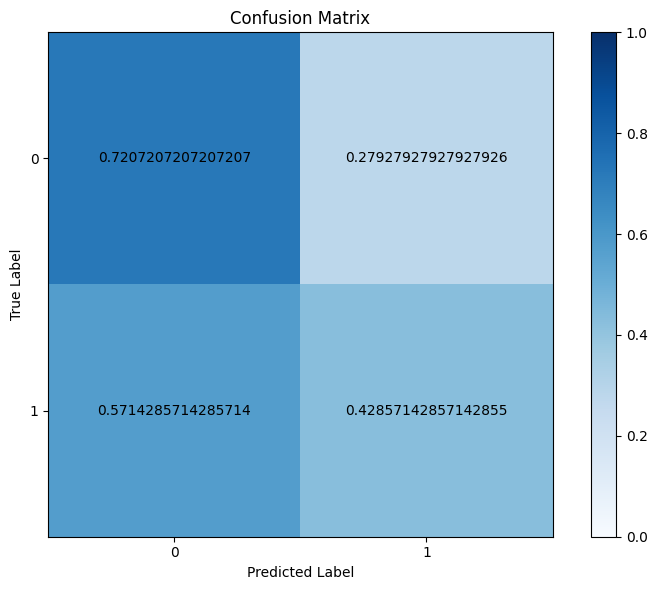

Train tracks shape:  (664, 13)


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_65          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7628 - loss: 0.7029 - val_accuracy: 0.8043 - val_loss: 0.5538
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6939 - loss: 0.6964 - val_accuracy: 0.7609 - val_loss: 0.6232
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6191 - loss: 0.6954 - val_accuracy: 0.6377 - val_loss: 0.6771
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6091 - loss: 0.6767 - val_accuracy: 0.4783 - val_loss: 0.7017
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5665 - loss: 0.6751 - val_accuracy: 0.4638 - val_loss: 0.7018
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6354 - loss: 0.6457 - val_accuracy: 0.5072 - val_loss: 0.7057
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6002 - loss: 0.6575 - val_accuracy: 0.5145 - val_loss: 0.7053
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6282 - loss: 0.6260 - val_accuracy: 0.5000 - val_loss:

In [ ]:
conf_matrix_cellfate, conf_matrix_tabular = data_size_study(dataset_size, train_images, train_labels, train_tracks, test_images, test_labels, test_tracks, x_train_full, seed=42)

In [7]:
conf_matrix_cellfate

array([[[0.52252252, 0.47747748],
        [0.32142857, 0.67857143]],

       [[0.54054054, 0.45945946],
        [0.21428571, 0.78571429]],

       [[0.63963964, 0.36036036],
        [0.46428571, 0.53571429]],

       [[0.57657658, 0.42342342],
        [0.25      , 0.75      ]],

       [[0.63063063, 0.36936937],
        [0.25      , 0.75      ]]])

In [8]:
conf_matrix_tabular

array([[[0.63963964, 0.36036036],
        [0.35714286, 0.64285714]],

       [[0.56756757, 0.43243243],
        [0.39285714, 0.60714286]],

       [[0.57657658, 0.42342342],
        [0.17857143, 0.82142857]],

       [[0.62162162, 0.37837838],
        [0.35714286, 0.64285714]],

       [[0.6036036 , 0.3963964 ],
        [0.32142857, 0.67857143]]])